## Differential RNA expression analysis

### Install rpy2 to run R code

In [ ]:
!pip3 install rpy2==3.5.1

In [ ]:
%load_ext rpy2.ipython

### Install conda

In [ ]:
%%bash

wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 

### Input data

We will explore how RNA expression levels change as yeast undergo fermentation to make bread rise. There are two replicates of RNA-seq data from yeast before and during fermentation, and our goal is to find out if the yeast express different genes during fermentation than they do under normal growth

In [ ]:
!wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR941/SRR941816/SRR941816.fastq.gz
!wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR941/SRR941817/SRR941817.fastq.gz
!wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR941/SRR941818/SRR941818.fastq.gz
!wget ftp.sra.ebi.ac.uk/vol1/fastq/SRR941/SRR941819/SRR941819.fastq.gz


As a reference genome we will use Saccharomyces cerevisiae, in the genome database at NCBI. Make sure you have strain S288c and assembly R64.

In [ ]:
!wget ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz
!wget ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.gff.gz

In [ ]:
!gunzip *.gz

### Analysis Pipeline


#### Aligning with HISAT2

In [ ]:
!apt-get install hisat2

In [ ]:
%%bash

git clone https://github.com/DaehwanKimLab/hisat2.git
cd hisat2
make

build genome index

In [ ]:
!hisat2-build GCF_000146045.2_R64_genomic.fna genome_index

In [ ]:
%%bash

hisat2 -p 4 -x genome_index -U SRR941816.fastq | samtools sort > min0_r1.bam
hisat2 -p 4 -x genome_index -U SRR941818.fastq | samtools sort > min30_r1.bam
hisat2 -p 4 -x genome_index -U SRR941817.fastq | samtools sort > min0_r2.bam
hisat2 -p 4 -x genome_index -U SRR941819.fastq | samtools sort > min30_r2.bam

#### Quantifying with featureCounts

In [ ]:
!conda install -c bioconda gffread

In [ ]:
!gffread GCF_000146045.2_R64_genomic.gff -T -o genome_annot.gtf

In [ ]:
!conda install -c bioconda subread

In [ ]:
!featureCounts -g gene_id -a genome_annot.gtf -o fC_output min0_r1.bam min0_r2.bam min30_r1.bam min30_r2.bam

In [ ]:
!cat fC_output | cut -f 1,7-10 > simple_counts.txt

### Find differentially expressed genes with Deseq2

In [ ]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

In [ ]:
%%R
cat simple_counts.txt | R -f deseq2.r

In [ ]:
%%bash

cat norm-matrix-deseq2.txt | R -f draw-heatmap.r

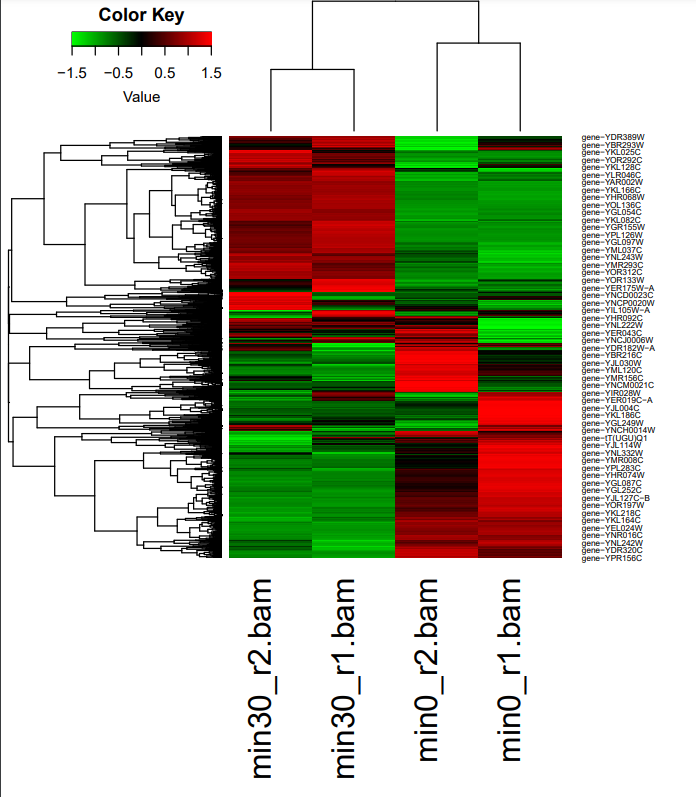

In [ ]:
%%bash

awk '$4>0 {print $0}' result.txt | head -n 50 > best50_up.txt
cat best50_up.txt | cut -f 1 | cut -d "-" -f 2 > genes_up.txt
awk '$4<0 {print $0}' result.txt | head -n 50 > best50_down.txt
cat best50_down.txt | cut -f 1 | cut -d "-" -f 2 > genes_down.txt

	id	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj

In [ ]:
%%bash

wget https://go.princeton.edu/tmp//2917_slimTerms.html
wget https://go.princeton.edu/tmp//2901_slimTerms.html

### Down-regulated genes

Most common GO-terms in significantly down-regulated genes were: \
1. "carbohydrate metabolic process (GO:0005975)"(13 genes) \
2. "generation of precursor metabolites and energy (GO:0006091)"(12 genes)


YBR053C - Uncharacterized \
ARA1 / YBR149W - NADP+ dependent arabinose dehydrogenase; involved in carbohydrate metabolism 

### Up-regulated genes